# Imports

In [6]:
import json 
import string
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')
from nltk import pos_tag
import joblib

C:\Users\mosmi\AppData\Local\Temp\ipykernel_25664\1794479649.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [4]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Functions

### 1. Data cleaning

In [1]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\S*\d\S*\s*','', text)
    text = re.sub('\[.*\]','', text)

    return text

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]

    return filtered_tokens

def tokenize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    return tokens

### 2. Merge cleaning functions to one function

In [2]:
def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    tokens_without_stopwords = remove_stopwords(tokens)
    preprocessed_text = ' '.join(tokens_without_stopwords)
    
    return preprocessed_text

### 3. Restore basic forms of words

In [3]:
def lemmatize(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]

    return ' '.join(sent)

def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    
    return ' '.join(stem_words)

def remove_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']

    return ' '.join(sent)

# finding ngrams

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [9]:
with open('data/complaints.json') as f:
    data = json.load(f)
data = pd.json_normalize(data)

In [10]:
data.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
data.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#pick only columns which are needed
data = data[['_source.complaint_what_happened', '_source.issue', '_source.product', '_source.sub_product']]

#rename for normal names
data = data.rename(columns={'_source.complaint_what_happened': 'complaint',  '_source.issue' : 'issue', '_source.product': 'product','_source.sub_product': 'sub_product'})

# drop columns with blank description
data[data['complaint']==''] = np.nan
data = data[~data['complaint'].isnull()]

data.head()

,complaint,issue,product,sub_product
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Written notification about debt,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,"Other features, terms, or problems",Credit card or prepaid card,General-purpose credit card or charge card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Managing an account,Checking or savings account,Checking account


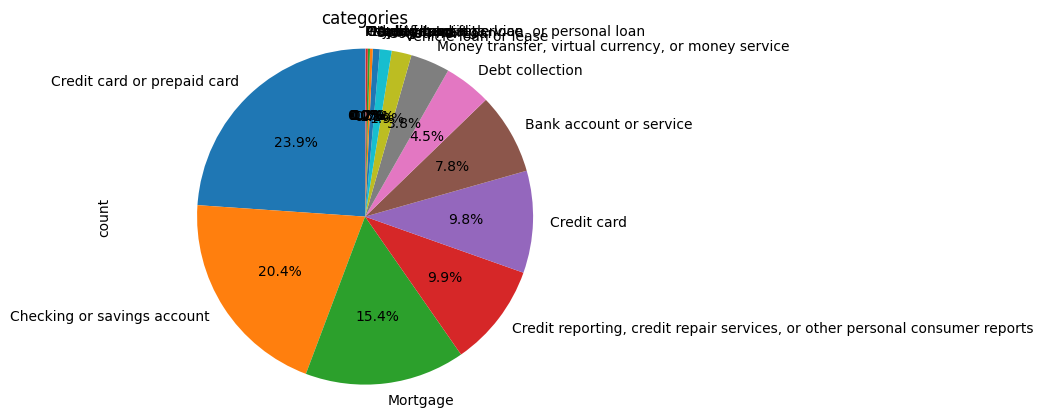

In [12]:
counts = data['product'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [13]:
# creating new column with merged 3 columns for category and droping previous columns
data['category'] = data['issue'] + ' / ' + data['product'] + ' / ' + data['sub_product']
data.drop(['issue', 'product', 'sub_product'], axis=1, inplace=True)

# text cleaning

In [14]:
data['text_clean'] = data['complaint'].apply(lambda x: preprocess_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x: lemmatize(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_pos_tags(x))

data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data['text_clean'].str.replace('xxxx','')


### Check data

(array([8.454e+03, 6.287e+03, 3.049e+03, 1.433e+03, 8.430e+02, 4.590e+02,
        1.820e+02, 1.050e+02, 6.000e+01, 5.400e+01, 2.500e+01, 3.200e+01,
        1.400e+01, 1.000e+01, 1.200e+01, 8.000e+00, 9.000e+00, 4.000e+00,
        6.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.  ,   209.32,   418.64,   627.96,   837.28,  1046.6 ,
         1255.92,  1465.24,  1674.56,  1883.88,  2093.2 ,  2302.52,
         2511.84,  2721.16,  2930.48,  3139.8 ,  3349.12,  3558.44,
         3767.76,  3977.08,  4186.4 ,  4395.72,  4605.04,  4814.36,
         5023.68,  5233.  ,  5442.32,  5651.64,  5860.96,  6070.28,
         6279.6 ,  6488.92,  6698.24

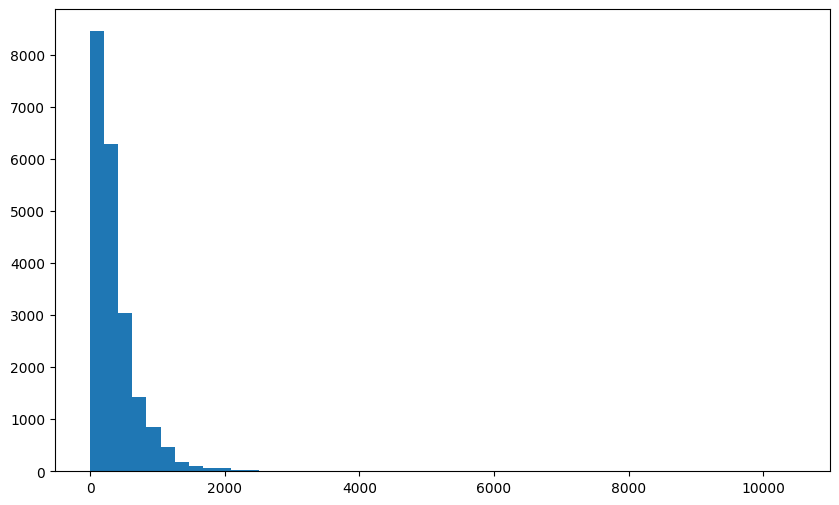

In [16]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in data['text_clean']]
plt.hist(doc_lens, bins = 50)

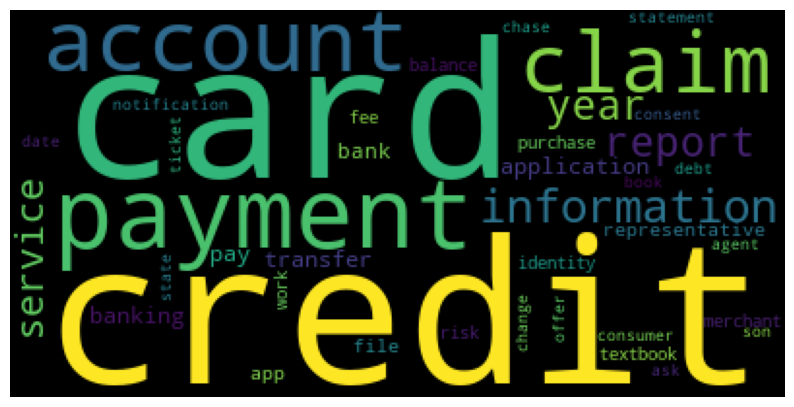

In [17]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM, LDA or LSA
###
###
###

### Finding top n-grams

### Vectorizer

In [7]:
# tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english', ngram_range=(1, 2))
# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

dtm = tfidf.fit_transform(data['text_clean']) # document term metrix
feature_names = np.array(tfidf.get_feature_names_out())

# cv = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = cv.fit_transform(data['text_clean']) # document term metrix
# feature_names = np.array(cv.get_feature_names_out())

### NFM

In [8]:
from sklearn.preprocessing import normalize

num_topics = 5  # You can adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
# nmf_model = NMF(n_components=num_topics)
nmf_matrix = nmf_model.fit_transform(dtm)

# Normalize the NMF matrix
nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)


for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")

Top 15 words for Topic 0:

['account', 'check', 'money', 'bank', 'deposit', 'fund', 'day', 'branch', 'transfer', 'number', 'business', 'transaction', 'chase', 'customer', 'claim']


Top 15 words for Topic 1:

['credit', 'card', 'report', 'inquiry', 'account', 'score', 'company', 'information', 'chase', 'limit', 'application', 'debt', 'letter', 'year', 'balance']


Top 15 words for Topic 2:

['payment', 'balance', 'month', 'pay', 'statement', 'fee', 'time', 'day', 'mortgage', 'date', 'credit', 'year', 'auto', 'account', 'error']


Top 15 words for Topic 3:

['charge', 'card', 'dispute', 'fee', 'transaction', 'purchase', 'merchant', 'claim', 'service', 'refund', 'fraud', 'time', 'email', 'statement', 'balance']


Top 15 words for Topic 4:

['loan', 'mortgage', 'modification', 'home', 'property', 'year', 'letter', 'document', 'rate', 'request', 'time', 'foreclosure', 'refinance', 'information', 'sale']




In [9]:
data.topic.value_counts()

topic
0    5117
3    4926
1    4815
4    3818
2    2374
Name: count, dtype: int64

### MAPPING AND SAVING DF

In [41]:
# 'Reporting/information',
# 'Credit/debits Cards',
# 'Other',
# 'Banking and Account activities',
# 'Loans/Mortgages'



topic_mapping = {
    0: 'Banking and Account activities',
    1: 'Credit/debits Cards',
    2: 'Other',
    3: 'Reporting/information',
    4: 'Loans/Mortgages'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

In [ ]:
data.to_csv('data/data.csv', index=False) # saving dataset

### VISUALISE DATA FOR EACH NEWLY CREATED TOPIC

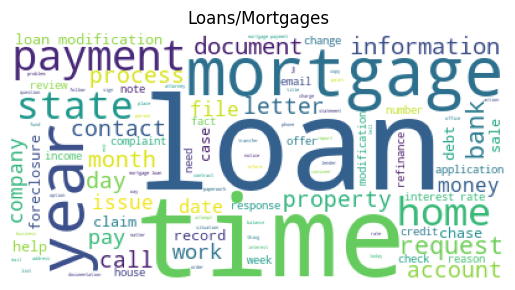

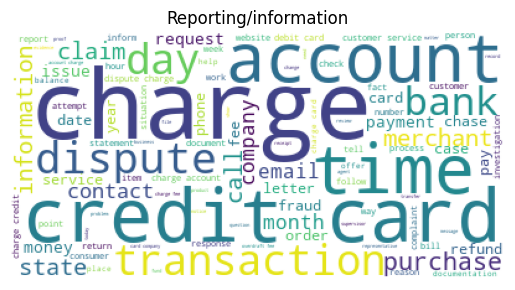

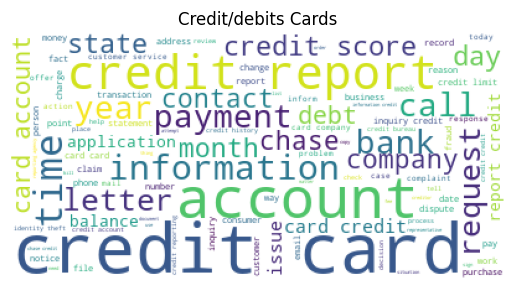

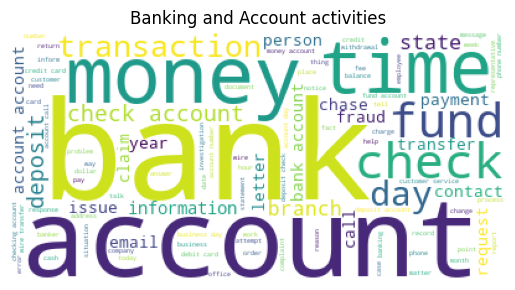

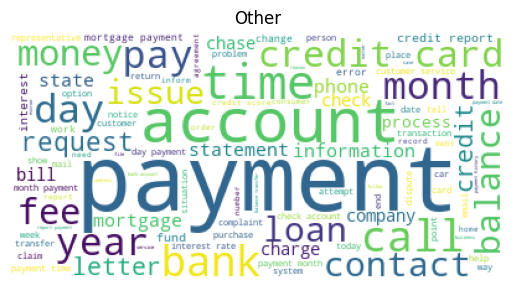

In [42]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	# wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

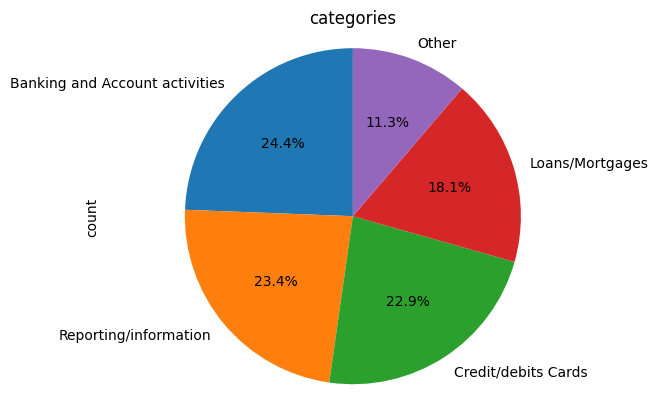

In [43]:
counts = data['topic'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [ ]:
import pandas as pd
from textaugment import Wordnet

# Data Augmentation

In [51]:
topic_counts = data['topic'].value_counts() # get the topic for each category
max_count = topic_counts.max() # max items for main topic

augmented_data = []
wordnet_aug = Wordnet(v=True) # use Wordnet for synonims

# loop for creating additional data
for topic, count in topic_counts.items():
    if count < max_count:
        topic_data = data[data['topic'] == topic]
        samples_needed = max_count - count # find how many text data we need to add for each group
        
        # perform augmenation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            augmented_sentence = wordnet_aug.augment(topic_data['text_clean'].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)
        
        # create new dataframe with merged newly created samples and topics
        augmented_df = pd.DataFrame({'topic': [topic] * len(augmented_sentences), 'text_clean': augmented_sentences})
        
        # add samples from list to dataframe
        augmented_data.append(augmented_df)

# merge newly created dataframe with samples and oryginal data
augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

# print the results
print("Orginal data counts :")
print(data.topic.value_counts())
print("\nAugmented data counts :")
print(augmented_data.topic.value_counts())


Orginal data counts :
topic
Banking and Account activities    5117
Reporting/information             4924
Credit/debits Cards               4817
Loans/Mortgages                   3818
Other                             2374
Name: count, dtype: int64

Augmented data counts :
topic
Loans/Mortgages                   5117
Reporting/information             5117
Credit/debits Cards               5117
Banking and Account activities    5117
Other                             5117
Name: count, dtype: int64


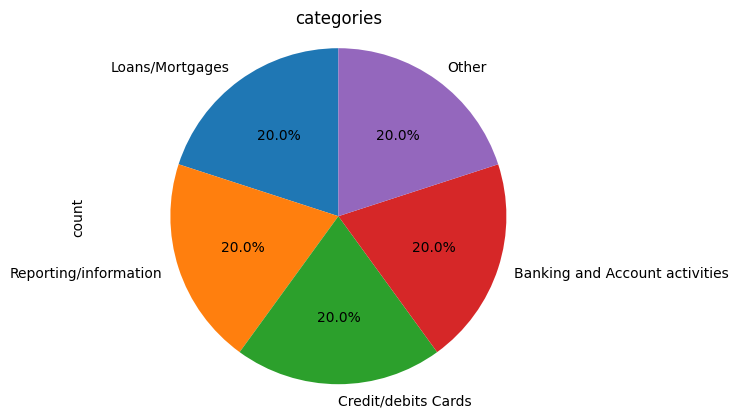

In [64]:
counts = augmented_data['topic'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [52]:
augmented_data.to_csv('data/augmented_data.csv', index=False) # saving dataset

# Machine Learning

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

df_scores = df = pd.DataFrame(columns=['Model', 'Training Score', 'Test Score']) 

In [6]:
def display_classification_results(model, X_train, y_train, X_test, y_test, model_name):
    global df_scores
    
    try:
        # Training data predictions
        y_train_pred = model.predict(X_train)
        
        # Test data predictions
        y_test_pred = model.predict(X_test)
        
        # Accuracy Scores
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Classification reports
        train_classification_report = classification_report(y_train, y_train_pred)
        test_classification_report = classification_report(y_test, y_test_pred)
    
    #inputs for some methods needs to be as array instead of string
    except:
        y_train_pred = model.predict(X_train.toarray())
        
        # Test data predictions
        y_test_pred = model.predict(X_test.toarray())

         # Accuracy Scores
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Classification reports
        train_classification_report = classification_report(y_train, y_train_pred)
        test_classification_report = classification_report(y_test, y_test_pred)

    #add scores to dataframe
    df_scores = df_scores._append({'Model': model_name, 'Training Score': train_accuracy, 'Test Score': test_accuracy}, ignore_index=True)

    #print scores
    print("\nTraining Accuracy:", train_accuracy)
    print("\nTraining Classification Report:")
    print(train_classification_report)
    
    print("Testing Accuracy:", test_accuracy)
    print("\nTesting Classification Report:")
    print(test_classification_report)
    
    # Confusion Matrix
    unique_classes = np.unique(np.concatenate([y_train, y_test]))
    cm = confusion_matrix(y_test, y_test_pred, normalize='true')  # Normalize confusion matrix
    plt.figure(figsize=(15, 6))
    
    # Change color map to Greens
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens", xticklabels=unique_classes, yticklabels=unique_classes)
    
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


In [7]:
# import dataset
data = pd.read_csv('data/augmented_data.csv')
data['text_clean'] = data['text_clean'].fillna('')
data[data['text_clean']==''] = np.nan
data = data[~data['text_clean'].isnull()]


In [ ]:
training_data = data[['text_clean','topic']]
training_data['text_clean'] = training_data['text_clean'].fillna('')
training_data[training_data['text_clean']==''] = np.nan
training_data = training_data[~training_data['text_clean'].isnull()]

In [8]:
training_data = data[['text_clean','topic']]
X = training_data['text_clean']
y = training_data['topic']

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
cv = CountVectorizer()
X_vec = cv.fit_transform(X)
tfidf_t = TfidfTransformer()
X_tfidf = tfidf_t.fit_transform(X_vec)
joblib.dump(cv, 'pre-trained_models/cv.joblib')
joblib.dump(tfidf_t, 'pre-trained_models/tfidf.joblib')

['pre-trained_models/tfidf.joblib']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=40, stratify=y)

In [13]:
# scaller for log reg

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression Classificator


Training Accuracy: 0.9824115692788743

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.98      0.99      0.99      4094
           Credit/debits Cards       0.98      0.98      0.98      4094
               Loans/Mortgages       0.98      0.98      0.98      4094
                         Other       0.98      0.99      0.99      4093
         Reporting/information       0.98      0.97      0.98      4093

                      accuracy                           0.98     20468
                     macro avg       0.98      0.98      0.98     20468
                  weighted avg       0.98      0.98      0.98     20468

Testing Accuracy: 0.9620871604455736

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.96      0.96      1023
           Credit/debits Cards       0.97      0.95      0.96  

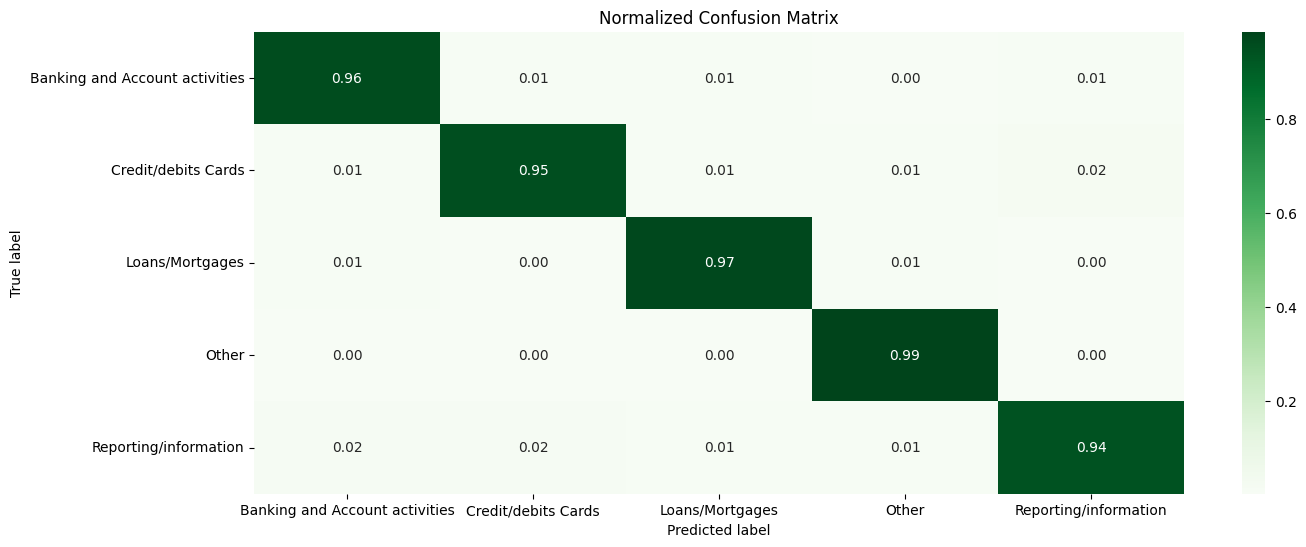

In [14]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
joblib.dump(log_reg, 'pre-trained_models/logistic_regression.joblib')
display_classification_results(log_reg, X_train, y_train, X_test, y_test, 'Logistic Regression')

### Decision Tree Classificator

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifie



Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4094
               Loans/Mortgages       1.00      1.00      1.00      4094
                         Other       1.00      1.00      1.00      4093
         Reporting/information       1.00      1.00      1.00      4093

                      accuracy                           1.00     20468
                     macro avg       1.00      1.00      1.00     20468
                  weighted avg       1.00      1.00      1.00     20468

Testing Accuracy: 0.8749267148719954

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.85      0.84      0.85      1023
           Credit/debits Cards       0.86      0.87      0.86      1023
      

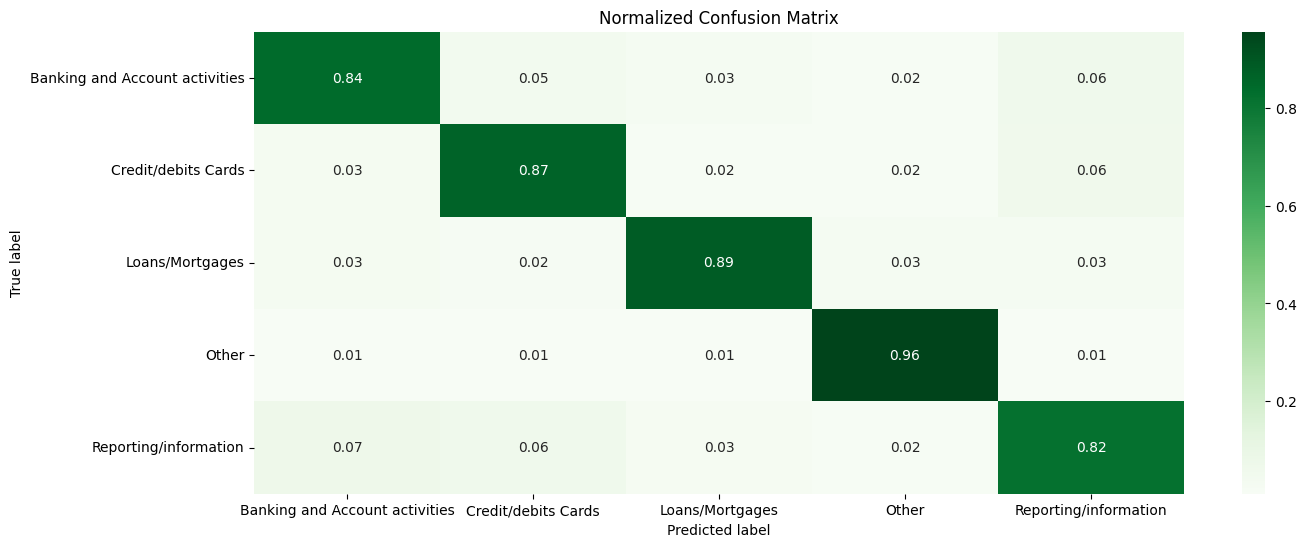

In [71]:
decision_tree = DecisionTreeClassifier(random_state=40)
decision_tree.fit(X_train,y_train)
display_classification_results(decision_tree, X_train, y_train, X_test, y_test, 'decision_tree')

### Random Forest Classificator


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4094
               Loans/Mortgages       1.00      1.00      1.00      4094
                         Other       1.00      1.00      1.00      4093
         Reporting/information       1.00      1.00      1.00      4093

                      accuracy                           1.00     20468
                     macro avg       1.00      1.00      1.00     20468
                  weighted avg       1.00      1.00      1.00     20468

Testing Accuracy: 0.9196794997068595

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.89      0.93      0.91      1023
           Credit/debits Cards       0.90      0.89      0.90      1023
      

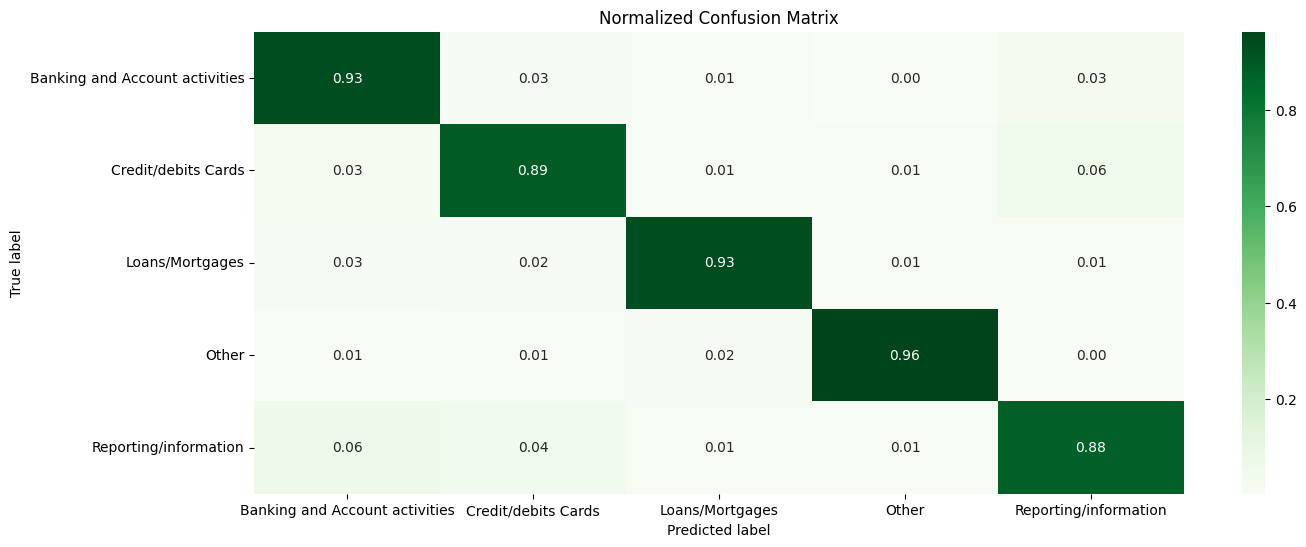

In [75]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=40)
random_forest.fit(X_train,y_train)
display_classification_results(random_forest, X_train, y_train, X_test, y_test, 'Random Forest')

### Support Vector Machine (SVM) Classificator


Training Accuracy: 0.9914500683994528

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.99      0.99      0.99      4094
           Credit/debits Cards       0.99      0.99      0.99      4094
               Loans/Mortgages       0.99      0.99      0.99      4094
                         Other       0.99      1.00      0.99      4093
         Reporting/information       0.99      0.98      0.99      4093

                      accuracy                           0.99     20468
                     macro avg       0.99      0.99      0.99     20468
                  weighted avg       0.99      0.99      0.99     20468

Testing Accuracy: 0.9585694743013484

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.95      0.95      1023
           Credit/debits Cards       0.95      0.96      0.95  

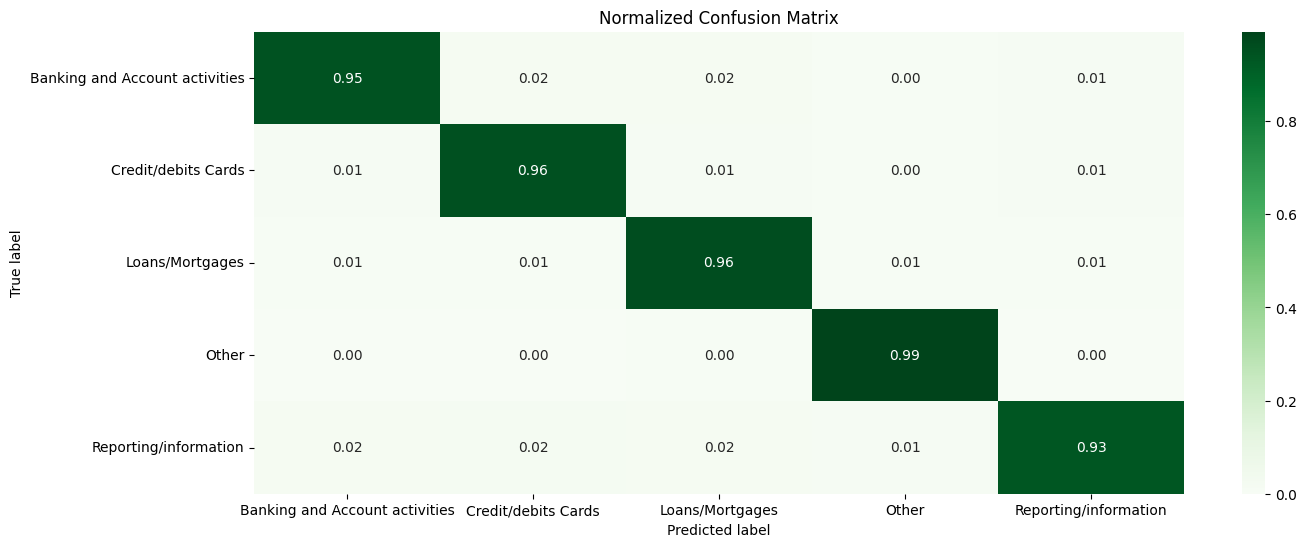

In [76]:
svm_classifier = SVC(kernel='linear',probability=True, random_state=40)
svm_classifier.fit(X_train,y_train)
display_classification_results(svm_classifier, X_train, y_train, X_test, y_test, 'Support Vector Machine')

### K-Nearest Neighbors Classificator


Training Accuracy: 0.5324408833300762

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.31      0.97      0.47      4094
           Credit/debits Cards       0.89      0.45      0.60      4094
               Loans/Mortgages       0.92      0.30      0.45      4094
                         Other       0.92      0.64      0.75      4093
         Reporting/information       0.92      0.30      0.46      4093

                      accuracy                           0.53     20468
                     macro avg       0.79      0.53      0.55     20468
                  weighted avg       0.79      0.53      0.55     20468

Testing Accuracy: 0.45143638850889195

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.28      0.96      0.43      1023
           Credit/debits Cards       0.86      0.41      0.55 

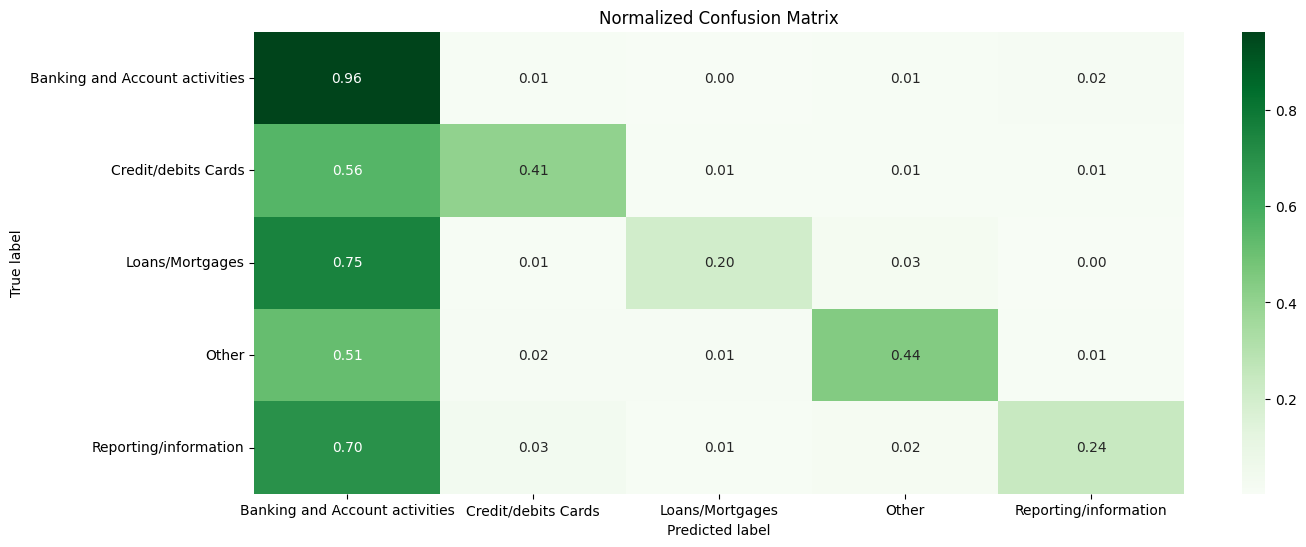

In [77]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train,y_train)
display_classification_results(knn_classifier, X_train, y_train, X_test, y_test, 'K-Nearest Neighbors')

### Naive Bayes Classificator


Training Accuracy: 0.5848153214774282

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.85      0.47      0.61      4094
           Credit/debits Cards       0.63      0.50      0.55      4094
               Loans/Mortgages       1.00      0.50      0.66      4094
                         Other       0.37      1.00      0.54      4093
         Reporting/information       0.98      0.46      0.62      4093

                      accuracy                           0.58     20468
                     macro avg       0.77      0.58      0.60     20468
                  weighted avg       0.77      0.58      0.60     20468

Testing Accuracy: 0.3789329685362517

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.39      0.17      0.24      1023
           Credit/debits Cards       0.34      0.23      0.27  

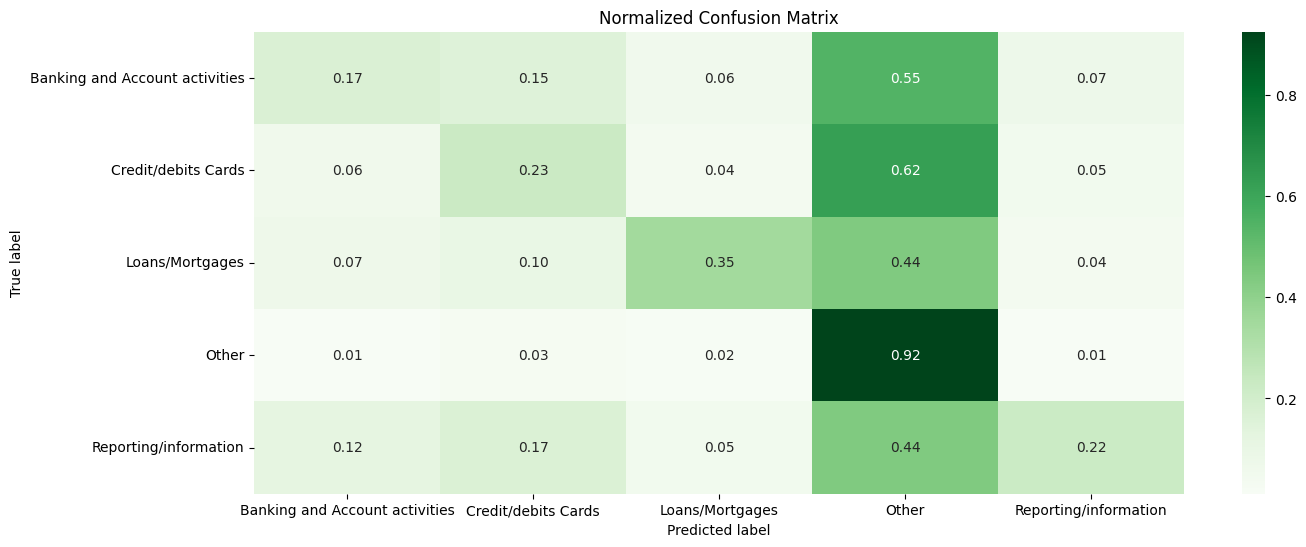

In [78]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train.toarray(),y_train)
display_classification_results(naive_bayes, X_train, y_train, X_test, y_test, 'Naive Bayes')

### AdaBoost Classificator


Training Accuracy: 0.8520128981825288

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.88      0.87      0.88      4094
           Credit/debits Cards       0.85      0.87      0.86      4094
               Loans/Mortgages       0.82      0.82      0.82      4094
                         Other       0.84      0.92      0.88      4093
         Reporting/information       0.87      0.78      0.82      4093

                      accuracy                           0.85     20468
                     macro avg       0.85      0.85      0.85     20468
                  weighted avg       0.85      0.85      0.85     20468

Testing Accuracy: 0.8387727183896815

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.88      0.85      0.86      1023
           Credit/debits Cards       0.84      0.86      0.85  

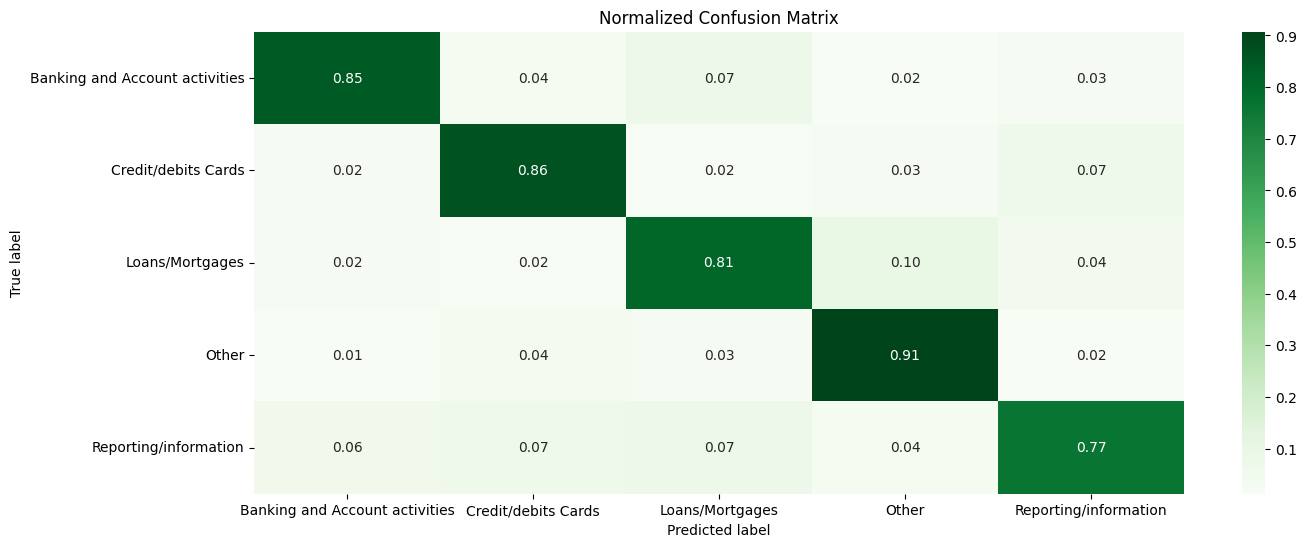

In [79]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=40)
adaboost.fit(X_train,y_train)
display_classification_results(adaboost, X_train, y_train, X_test, y_test, 'AdaBoost')

### Bagging Classificator


Training Accuracy: 0.9999022864959938

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4094
               Loans/Mortgages       1.00      1.00      1.00      4094
                         Other       1.00      1.00      1.00      4093
         Reporting/information       1.00      1.00      1.00      4093

                      accuracy                           1.00     20468
                     macro avg       1.00      1.00      1.00     20468
                  weighted avg       1.00      1.00      1.00     20468

Testing Accuracy: 0.9132304084424467

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.89      0.89      0.89      1023
           Credit/debits Cards       0.89      0.92      0.90  

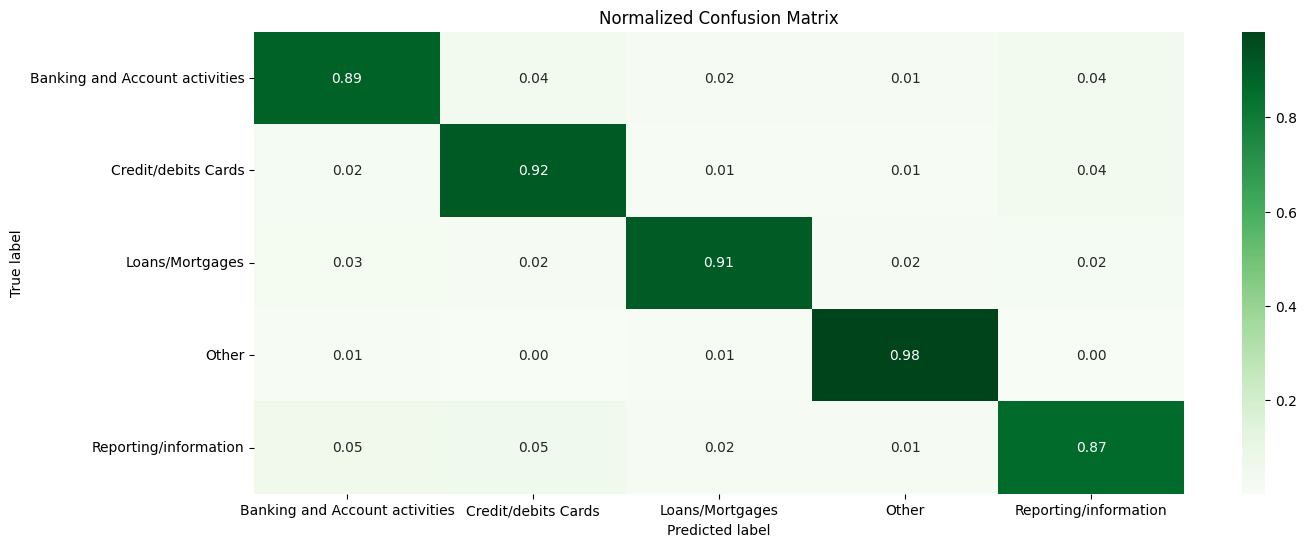

In [80]:
bagging = BaggingClassifier(n_estimators=50, random_state=40)
bagging.fit(X_train,y_train)
display_classification_results(bagging, X_train, y_train, X_test, y_test, 'Bagging Classifier')

### Extra Trees Classificator


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4094
               Loans/Mortgages       1.00      1.00      1.00      4094
                         Other       1.00      1.00      1.00      4093
         Reporting/information       1.00      1.00      1.00      4093

                      accuracy                           1.00     20468
                     macro avg       1.00      1.00      1.00     20468
                  weighted avg       1.00      1.00      1.00     20468

Testing Accuracy: 0.9149892515145593

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.88      0.93      0.90      1023
           Credit/debits Cards       0.89      0.90      0.89      1023
      

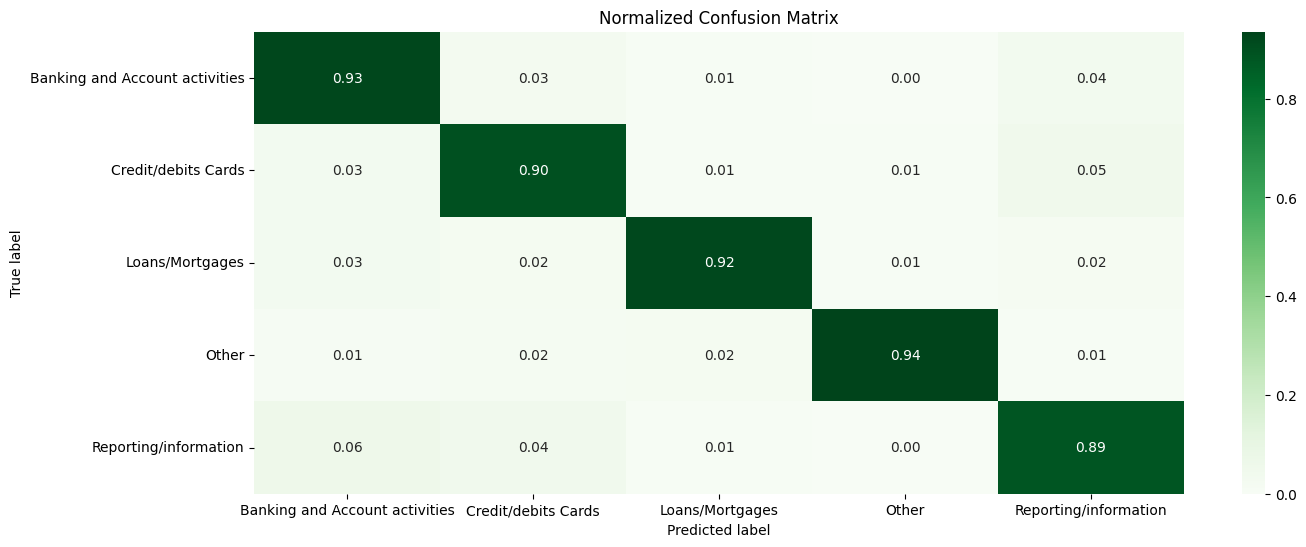

In [81]:
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=40)
extra_trees.fit(X_train,y_train)
display_classification_results(extra_trees, X_train, y_train, X_test, y_test, 'Extra Trees Classifier')

### Multi-layer Perceptron (Neural Networks) Classificator


Training Accuracy: 0.9999511432479968

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      4094
               Loans/Mortgages       1.00      1.00      1.00      4094
                         Other       1.00      1.00      1.00      4093
         Reporting/information       1.00      1.00      1.00      4093

                      accuracy                           1.00     20468
                     macro avg       1.00      1.00      1.00     20468
                  weighted avg       1.00      1.00      1.00     20468

Testing Accuracy: 0.9319914012116475

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.90      0.94      0.92      1023
           Credit/debits Cards       0.96      0.87      0.92  

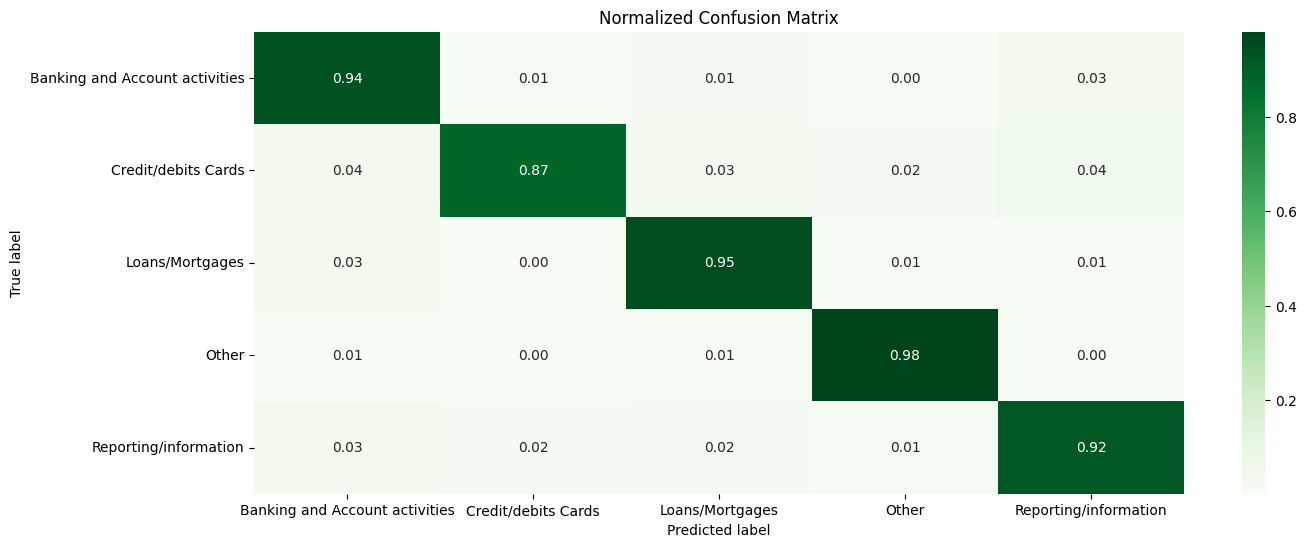

In [82]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=40)
mlp.fit(X_train,y_train)
display_classification_results(mlp, X_train, y_train, X_test, y_test, 'Multi-layer Perceptron')

### Gradient Boosting Classificator


Training Accuracy: 0.9624780144615986

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.96      0.96      4094
           Credit/debits Cards       0.97      0.96      0.96      4094
               Loans/Mortgages       0.95      0.96      0.96      4094
                         Other       0.97      0.99      0.98      4093
         Reporting/information       0.96      0.94      0.95      4093

                      accuracy                           0.96     20468
                     macro avg       0.96      0.96      0.96     20468
                  weighted avg       0.96      0.96      0.96     20468

Testing Accuracy: 0.9310142661715849

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.93      0.92      0.93      1023
           Credit/debits Cards       0.92      0.92      0.92  

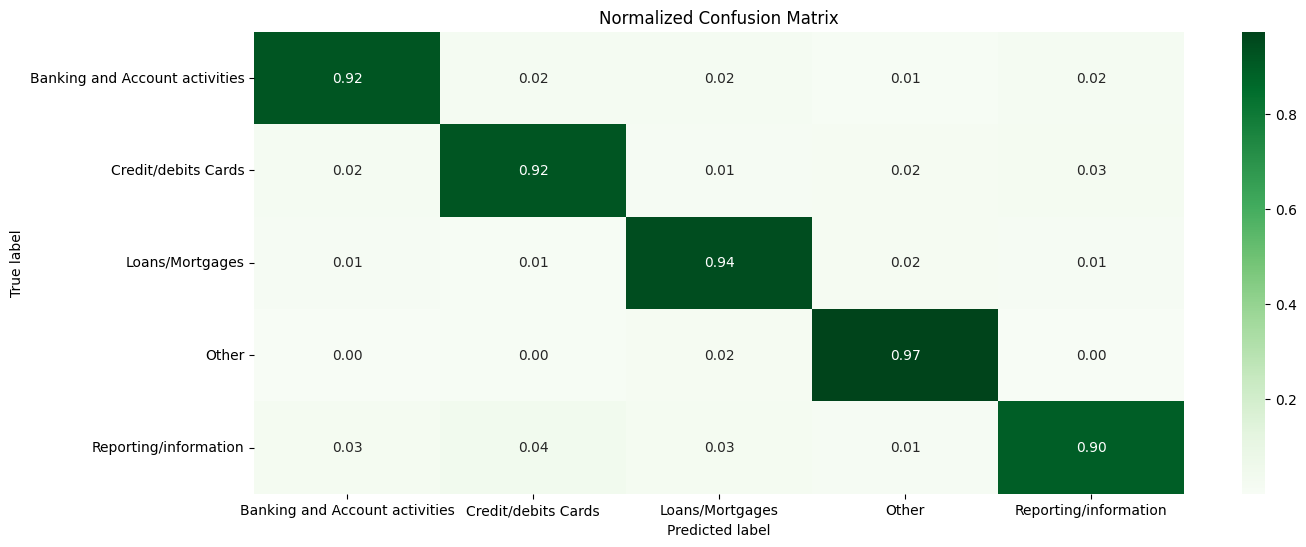

In [83]:
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=40)
gradient_boosting.fit(X_train,y_train)
display_classification_results(gradient_boosting, X_train, y_train, X_test, y_test, 'Gradient Boosting Classifier')

### Quadratic Discriminant Analysis Classificator


Training Accuracy: 0.9038499120578464

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.97      0.82      0.89      4094
           Credit/debits Cards       0.69      1.00      0.82      4094
               Loans/Mortgages       1.00      0.91      0.95      4094
                         Other       0.98      1.00      0.99      4093
         Reporting/information       1.00      0.80      0.89      4093

                      accuracy                           0.90     20468
                     macro avg       0.93      0.90      0.91     20468
                  weighted avg       0.93      0.90      0.91     20468

Testing Accuracy: 0.4983388704318937

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.40      0.35      0.37      1023
           Credit/debits Cards       0.40      0.57      0.47  

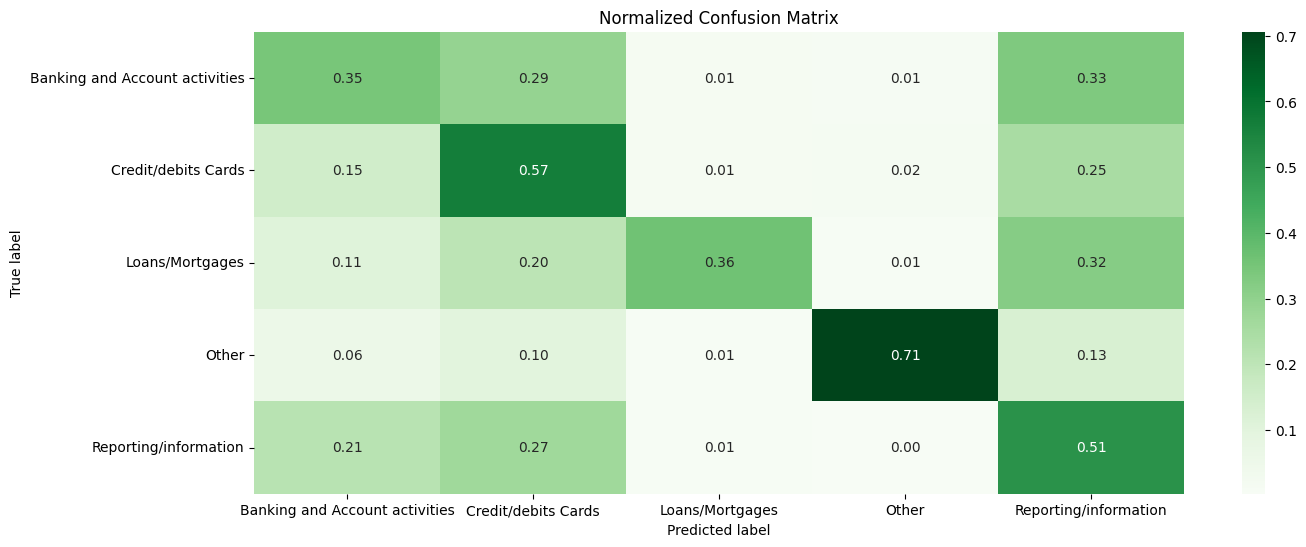

In [84]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train.toarray(),y_train)
display_classification_results(qda, X_train, y_train, X_test, y_test, 'Quadratic Discriminant Analysis')

In [ ]:
df_scores.sort_values(by='Test Score', ascending=False, inplace=True) # sorting my test scores
df_scores.to_csv('data/df_scores.csv', index=False) # saving dataset

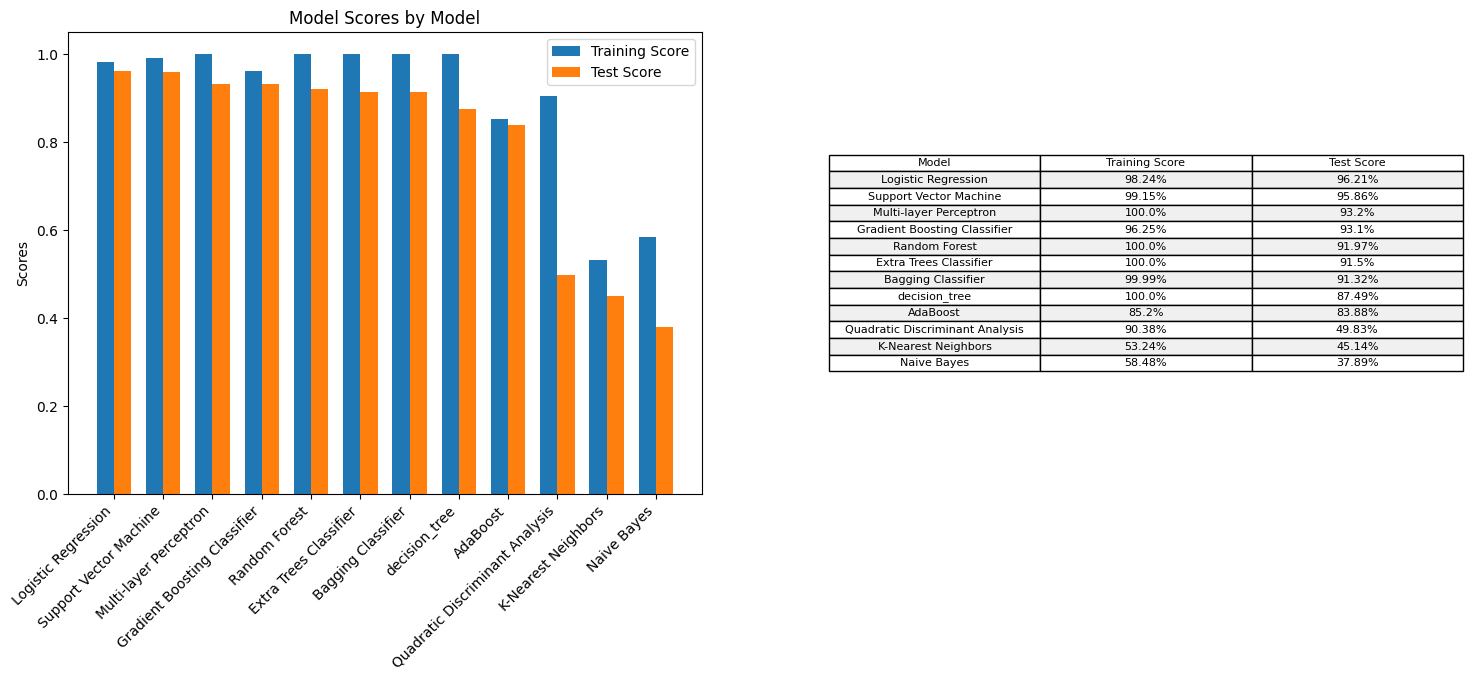

In [72]:
# Import dataset
df_scores = pd.read_csv('data/df_scores.csv')

# Merge 2 visualisations
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1]})

# Bar plot
x = range(len(df_scores))
rects1 = ax1.bar(x, df_scores['Training Score'], width, label='Training Score')
rects2 = ax1.bar([i + width for i in x], df_scores['Test Score'], width, label='Test Score')

# Labels for bar plot
ax1.set_ylabel('Scores')
ax1.set_title('Model Scores by Classificators')
ax1.set_xticks([i + width/2 for i in x])
ax1.set_xticklabels(df_scores['Model'], rotation=45, ha='right')
ax1.legend()

# Dataframe display
num_columns = df_scores.columns.difference(['Model'])
df_scores[num_columns] = df_scores[num_columns] * 100
df_scores[num_columns] = df_scores[num_columns].round(2).astype(str) + '%'

ax2.axis('off')
table_data = ax2.table(cellText=df_scores.values, colLabels=df_scores.columns, cellLoc='center', loc='center')
table_data.auto_set_font_size(False)
table_data.set_fontsize(8)

for i in range(len(df_scores)):
    for j in range(len(df_scores.columns)):
        cell_value = df_scores.iloc[i, j]
        color = '#f0f0f0' if i % 2 == 0 else '#ffffff'
        table_data[(i + 1, j)].set_facecolor(color)

plt.show()